In [1]:
!ls ../experiments/logs

ar_128		      attn_test_ar_32	   old_ar_32_mamba_ablation
ar_32		      attn_test_ar_32_wd   old_ar_32_mamba_ablation_d_conv
ar_32_1L	      difficulty	   old_ar_32_mamba_ablation_d_conv_2
ar_32_3L	      hyena_start	   pcfg_easy
ar_32_based_ablation  lr_sweep		   pcfg_easy_1L
ar_32_mamba_ablation  lr_sweep_gpt2	   pcfg_easy_8192
ar_32_more_lr	      lr_sweep_llama	   pcfg_easy_nope
ar_32_nope	      misc		   pcfg_medium
arch_easy	      new_lr_sweep	   pcfg_medium_8192
arch_evals	      new_lr_sweep_gpt2    pcfg_medium_nope
arch_sweep	      new_lr_sweep_llama
attn_test3	      new_lr_sweep_nodrop


In [34]:
!ls /nlp/scr/rathi/tinylang_logs/

ar_gen	   multihop    multihop_3  new_gen_1  sibling
gen_sweep  multihop_1  new_gen	   new_gen_3  sibling_3


In [2]:
import glob
import os
import pandas as pd
import plotnine as p9
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mpltern

In [3]:
p9.theme_set(
    p9.theme_bw(base_size=10) +
    p9.theme(
        text=p9.element_text(family="P052"),
        figure_size=(2.5, 2.5),
        axis_title=p9.element_text(size=10),
        axis_text=p9.element_text(size=8),
        legend_position="bottom",
        legend_text=p9.element_text(size=8),
        legend_title=p9.element_text(size=9),
        panel_grid_major=p9.element_line(size=0.3, color="#dddddd"),
        panel_grid_minor=p9.element_blank(),
        legend_justification_bottom=1,
        strip_background=p9.element_blank(),
    )
)

In [4]:
arch_names = {
    "attention": "Attention",
    "based": "Based",
    "base_conv": "BaseConv",
    "h3": "H3",
    "hyena": "Hyena",
    "mamba": "Mamba",
}

In [5]:
def read_df(dirs, filter_steps=5000):
    all_files = []
    for d in dirs:
        all_files.extend(list(glob.glob(d)))
    dfs = []
    for file in tqdm(all_files):
        dirname = os.path.dirname(file)
        evaluator = file.split("/")[-1].split(".")[0]
        split = dirname.split("/")[-1]
        arch, dim, lr = dirname.split("/")[-2].split(".")[0].split("___")
        log = pd.read_csv(file)
        log = log[(log["step"] % filter_steps) == 0]
        log["identifier"] = file
        log["arch"] = arch_names.get(arch, arch)
        log["dim"] = int(dim)
        log["lr"] = float(lr)
        log["evaluator"] = evaluator
        log["step_rel"] = log["step"] / log["step"].max()
        log["layers"] = 2
        log["dataset"] = dirname.split("/")[-3]
        log["split"] = split
        log = log.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset", "split"]).mean().reset_index()
        dfs.append(log)
    print(len(dfs))
    df = pd.concat(dfs)
    df = df.groupby(["variable", "step", "evaluator", "step_rel", "identifier", "arch", "dim", "lr", "layers", "dataset", "split"]).mean().reset_index()
    return df

In [6]:
positions = ["target_item_orig", "query_item_orig", "query_item", "divider"]

# get pivoted df
def get_attrib_df(df, df_int, corruption: str="query_item_orig", components: str | list[str]="block_input", prefix="KEY"):
    if isinstance(components, str):
        components = [components]
        
    subset_df = df[(df["variable"].isin(["query_item.argmax", "query_item.pred_prob"])) & (df["step_rel"] == 1.0)]
    subset_df_int = df_int[(df_int["step_rel"] == 1.0)]
    subset_df_int = pd.concat([subset_df_int, subset_df])
    subset_df_int["dataset"] = subset_df_int["dataset"].apply(lambda x: x.replace("_nope", ""))
    subset_df_int = subset_df_int[["dim", "arch", "lr", "variable", "value", "dataset", "split"]].pivot(index=["dim", "arch", "lr", "dataset", "split"], columns="variable").reset_index()
    subset_df_int.columns = [col[1] if col[1] != '' else col[0] for col in subset_df_int.columns]
    
    for component in components:
        for layer in range(2):
            for position in positions:
                metric = f"{layer}.{prefix}.{corruption}.{position}.{component}.restored_prob"
                corrupted = f"corrupted.{prefix}.{corruption}.{position}.{component}.restored_prob"
                diff = f"{layer}.{prefix}.{corruption}.{position}.{component}.prob_diff"
                original = f"original.{prefix}.{corruption}.{position}.{component}.restored_prob"
                kl_div = f"{layer}.{prefix}.{corruption}.{position}.{component}.kl_div"
                label = f"Association @ {layer}, {position}" if len(components) == 1 else f"Association @ {layer}, {position}, {component}"
                subset_df_int[label] = (subset_df_int[diff]) / (subset_df_int[original] - (subset_df_int[metric] - subset_df_int[diff]))
                
        for layer in range(2):
            for position in positions:
                metric = f"{layer}.{prefix}.{corruption}.{position}.{component}.restored_prob"
                corrupted = f"corrupted.{prefix}.{corruption}.{position}.{component}.restored_prob"
                diff = f"{layer}.{prefix}.{corruption}.{position}.{component}.prob_diff"
                original = f"original.{prefix}.{corruption}.{position}.{component}.restored_prob"
                kl_div = f"{layer}.{prefix}.{corruption}.{position}.{component}.kl_div"
                suffix = f"{layer}, {position}" if len(components) == 1 else f"{layer}, {position}, {component}"
                subset_df_int = subset_df_int.rename(columns={
                    metric: f"Restored @ {suffix}",
                    corrupted: f"Corrupted @ {suffix}",
                    diff: f"Diff @ {suffix}",
                    original: f"Original @ {suffix}",
                    kl_div: f"KL @ {suffix}",
                })

    subset_df_int = subset_df_int.rename(columns={
        "query_item.argmax": "Accuracy",
        "query_item.pred_prob": "Likelihood",
    })

    return subset_df_int

## AR

In [74]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/SummaryEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)
df["arch"] = df.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
df["dataset"] = "ar_32"

  0%|          | 0/209 [00:00<?, ?it/s]


../experiments/logs/ar_32/attention___64___3e-05/test/SummaryEvaluator.csv


ValueError: not enough values to unpack (expected 3, got 1)

In [89]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 6.56 & 100.00 & 100.00 & 100.00 & 100.00 \\
BaseConv & 0.00 & 0.94 & 3.75 & 6.56 & 9.69 \\
Based & 24.38 & 93.12 & 99.06 & 98.75 & 99.06 \\
H3 & 0.94 & 0.62 & 1.88 & 2.50 & 1.56 \\
Hyena & 0.62 & 0.94 & 2.81 & 13.75 & 29.69 \\
Mamba & 10.00 & 76.88 & 80.62 & 89.69 & 91.25 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1317409/2876777681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


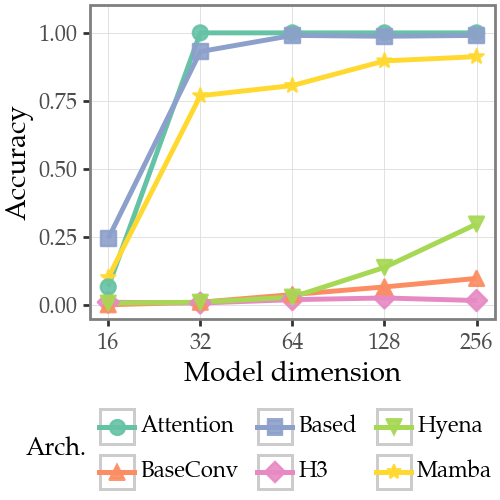

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32.pdf


In [90]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, stroke=0.5, alpha=0.9) +
    # Optional: label points with accuracy
    # p9.geom_text(p9.aes(label="clean"), size=6, va='bottom') +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(2.5, 2.5),
    )
)

plot.show()
plot.save("figs/ar_32.pdf", dpi=300)


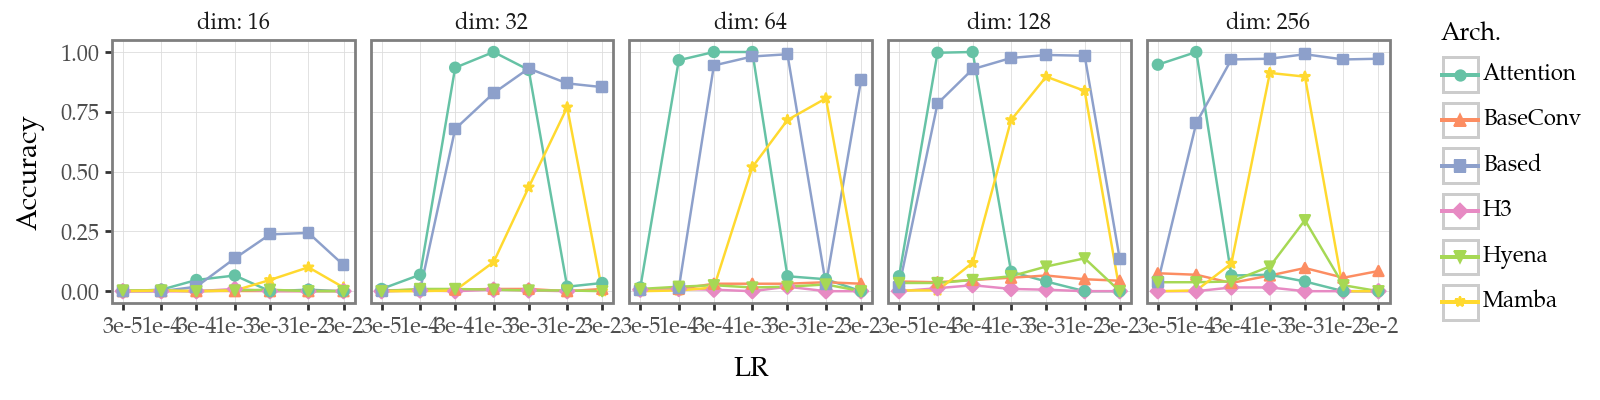

In [91]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_grid("~dim", labeller="label_both") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(8, 2),
        legend_position="right",
    )
)
plot.show()

In [92]:
dirs = [
    "../experiments/logs/ar_32/attention**/test/InterchangeEvaluator.csv",
    # "../experiments/logs/ar_32_nope/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/ar_32_more_lr/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)
df_int["arch"] = df_int.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
df_int["dataset"] = "ar_32"

100%|██████████| 208/208 [00:48<00:00,  4.27it/s]


208


In [93]:
subset_df_int = get_attrib_df(df, df_int)
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 220.13 & 100.00 & 100.00 & 100.00 & 100.00 \\
BaseConv & -3.24 & 35.89 & -148.30 & 67.26 & 204.15 \\
Based & 100.26 & 99.91 & 100.00 & 100.00 & 100.07 \\
H3 & -1.50 & -0.64 & 0.08 & 9.09 & 3.61 \\
Hyena & -0.15 & -0.62 & 0.01 & 0.00 & -0.00 \\
Mamba & -0.02 & 0.02 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



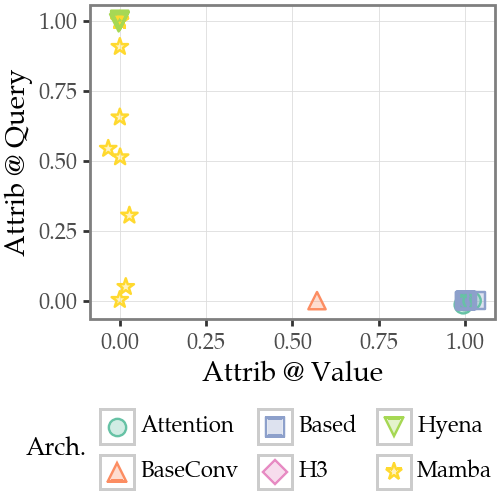

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32_diff_query_item_orig.pdf


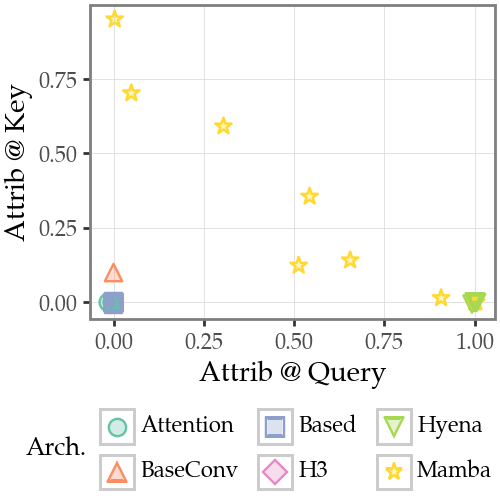

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/ar_32_diff_query_item_orig_q.pdf


In [94]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.01]
subset_df_int_plot["arch"] = pd.Categorical(subset_df_int_plot["arch"], categories=list(subset_df_int["arch"].unique()))
subset_df_int_plot["dim"] = pd.Categorical(subset_df_int_plot["dim"], categories=[x for x in sorted(subset_df_int_plot["dim"].unique())], ordered=True)
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item", color="arch", group="arch", shape="arch")) +
    p9.geom_point(stroke=0, alpha=0.3, size=3) + 
    p9.geom_point(fill="none", stroke=0.5, size=3) + 
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Value", y="Attrib @ Query") +
    p9.scale_color_brewer(type='qual', palette='Set2')
)
plot.show()
plot.save(f"figs/ar_32_diff_query_item_orig.pdf")

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item", y="Association @ 1, query_item_orig", color="arch", group="arch", shape="arch")) +
    p9.geom_point(stroke=0, alpha=0.3, size=3) + 
    p9.geom_point(fill="none", stroke=0.5, size=3) + 
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Query", y="Attrib @ Key") +
    p9.scale_color_brewer(type='qual', palette='Set2')
)
plot.show()
plot.save(f"figs/ar_32_diff_query_item_orig_q.pdf")

## Benchmarking ATR, varying $L$

In [7]:
dirs = [
    "../experiments/logs/pcfg_easy/attention**/test/SummaryEvaluator.csv",
    # "../experiments/logs/pcfg_easy_nope/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium/attention**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/h**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/b**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/m**/test/SummaryEvaluator.csv",
    "../experiments/logs/pcfg_easy_8192/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)

100%|██████████| 423/423 [00:59<00:00,  7.09it/s]


423


In [8]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["arch"] = subset_df.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

/tmp/user/23259/ipykernel_1443464/765897195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/user/23259/ipykernel_1443464/765897195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


\begin{tabular}{llllllllllllllll}
\toprule
 & \multicolumn{15}{r}{value} \\
dataset & \multicolumn{5}{r}{pcfg_easy} & \multicolumn{5}{r}{pcfg_easy_8192} & \multicolumn{5}{r}{pcfg_medium} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 68.44 & 90.31 & 93.75 & 95.31 & 96.25 & 72.50 & 84.06 & 89.38 & 86.88 & 86.56 & 50.94 & 56.88 & 75.62 & 80.62 & 80.94 \\
BaseConv & 67.50 & 75.62 & 82.50 & 86.88 & 90.00 & 42.50 & 46.56 & 55.94 & 59.69 & 66.25 & 55.94 & 61.56 & 65.31 & 70.62 & 68.75 \\
Based & 82.19 & 91.25 & 91.88 & 93.12 & 92.19 & 68.44 & 83.12 & 86.56 & 87.50 & 86.56 & 63.12 & 71.56 & 70.00 & 70.94 & 73.12 \\
H3 & 81.88 & 87.81 & 90.00 & 94.06 & 94.06 & 49.38 & 63.44 & 72.50 & 75.94 & 76.25 & NaN & NaN & NaN & NaN & NaN \\
Hyena & 75.94 & 80.94 & 85.31 & 92.50 & 93.75 & 45.94 & 57.81 & 64.69 & 69.06 & 70.00 & 57.81 & 63.75 & 62.50 & 66.25 & 68.44 \\
Mamba & 91.25 & 94.38

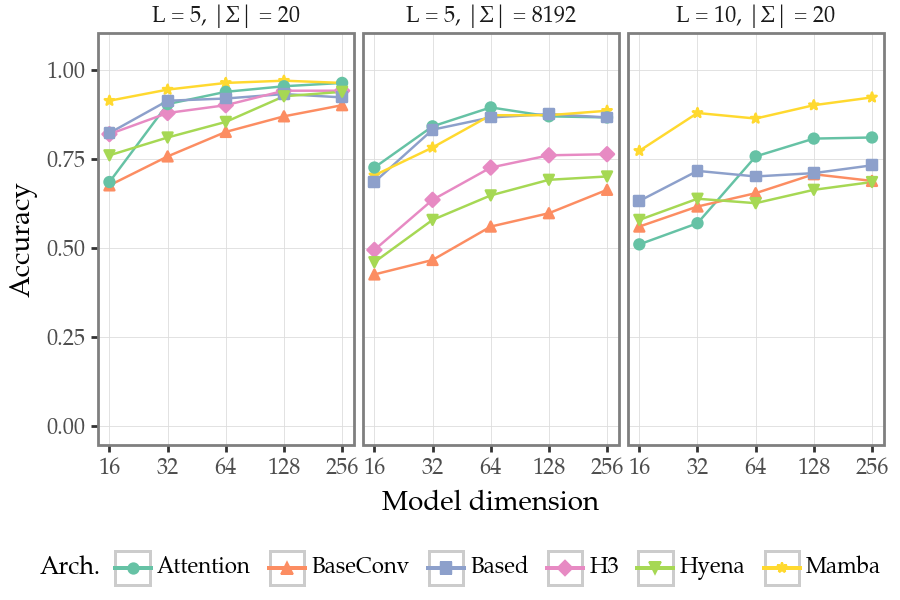

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr.pdf


In [9]:
subset_df_plot = subset_df.copy()
subset_df_plot["dataset"] = subset_df_plot["dataset"].map({
    "pcfg_easy": "L = 5, |Σ| = 20",
    "pcfg_easy_8192": "L = 5, |Σ| = 8192",
    "pcfg_medium": "L = 10, |Σ| = 20"
})
subset_df_plot["dataset"] = pd.Categorical(subset_df_plot["dataset"], categories=["L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20"], ordered=True)
plot = (
    p9.ggplot(subset_df_plot, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.ylim(0, 1.05) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/atr.pdf")

In [10]:
dirs = [
    "../experiments/logs/pcfg_easy/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium/attention**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/h**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/b**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_medium_nope/m**/test/InterchangeEvaluator.csv",
    "../experiments/logs/pcfg_easy_8192/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)

100%|██████████| 423/423 [02:32<00:00,  2.77it/s]


423


In [11]:
subset_df_int = get_attrib_df(df, df_int, corruption="query_item_orig", components="block_input", prefix="PARENT").reset_index()
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
 & \multicolumn{15}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{pcfg_easy} & \multicolumn{5}{r}{pcfg_easy_8192} & \multicolumn{5}{r}{pcfg_medium} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 23.09 & 109.29 & 102.24 & 107.19 & 102.69 & 93.81 & 90.00 & 99.23 & 86.36 & 84.77 & 11.55 & -23.18 & 112.20 & 117.13 & 109.59 \\
BaseConv & 39.82 & 27.36 & 51.08 & 69.12 & 68.92 & -2.83 & 18.92 & 20.37 & 28.35 & 61.02 & 49.96 & 49.33 & 52.78 & 59.49 & 77.11 \\
Based & 13.37 & 93.63 & 95.11 & 87.47 & 86.47 & 74.49 & 85.10 & 93.31 & 96.87 & 101.90 & 87.30 & 87.33 & 58.68 & 86.25 & 82.57 \\
H3 & 0.83 & 8.64 & 7.16 & 2.66 & 1.53 & -1.05 & 3.34 & 5.68 & -0.08 & -0.92 & NaN & NaN & NaN & NaN & NaN \\
Hyena & 4.97 & 11.95 & 11.46 & 0.09 & 6.77 & 23.32 & 1.20 & 7.97 & 5.70 & 0.73 & 17.33 & 3.67 & 14.48 & 5.42 & 9.01 \\
M

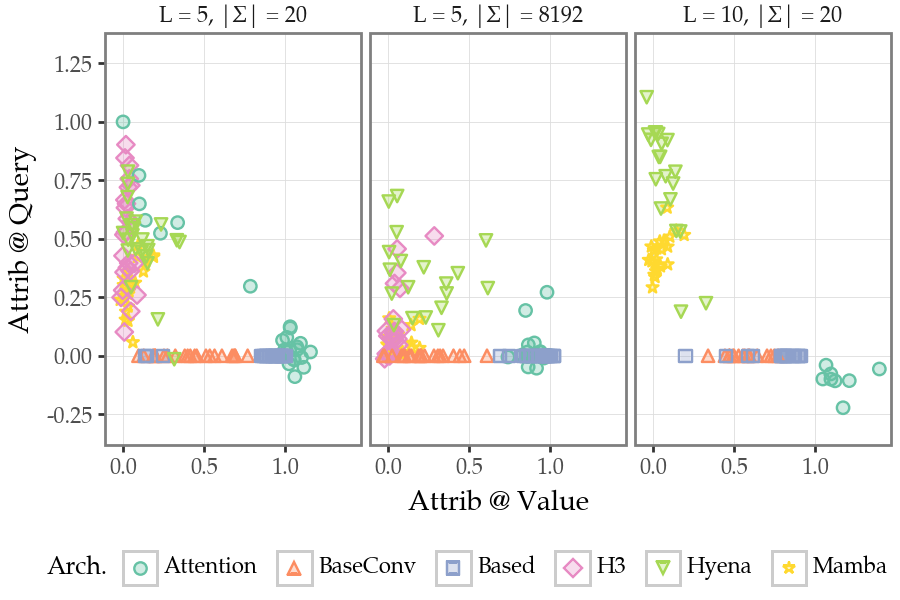

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_diff.pdf


In [12]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.1]
subset_df_int_plot["dataset"] = subset_df_int_plot["dataset"].map({
    "pcfg_easy": "L = 5, |Σ| = 20",
    "pcfg_easy_8192": "L = 5, |Σ| = 8192",
    "pcfg_medium": "L = 10, |Σ| = 20"
})
subset_df_int_plot["dataset"] = pd.Categorical(subset_df_int_plot["dataset"], categories=["L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20"], ordered=True)

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(x="Attrib @ Value", y="Attrib @ Query", color="Arch.", shape="Arch.") +
    # p9.scale_x_log10() +
    p9.scale_y_continuous(limits=(-0.3, 1.3), breaks=[-0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25]) +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/atr_diff.pdf")

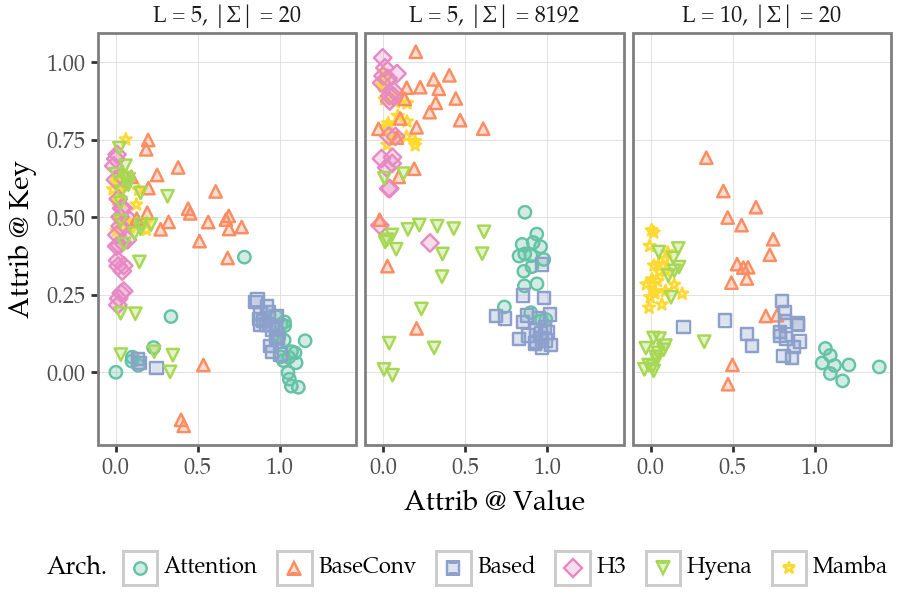

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_diff_k.pdf


In [13]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item_orig", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Value", y="Attrib @ Key") +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/atr_diff_k.pdf")

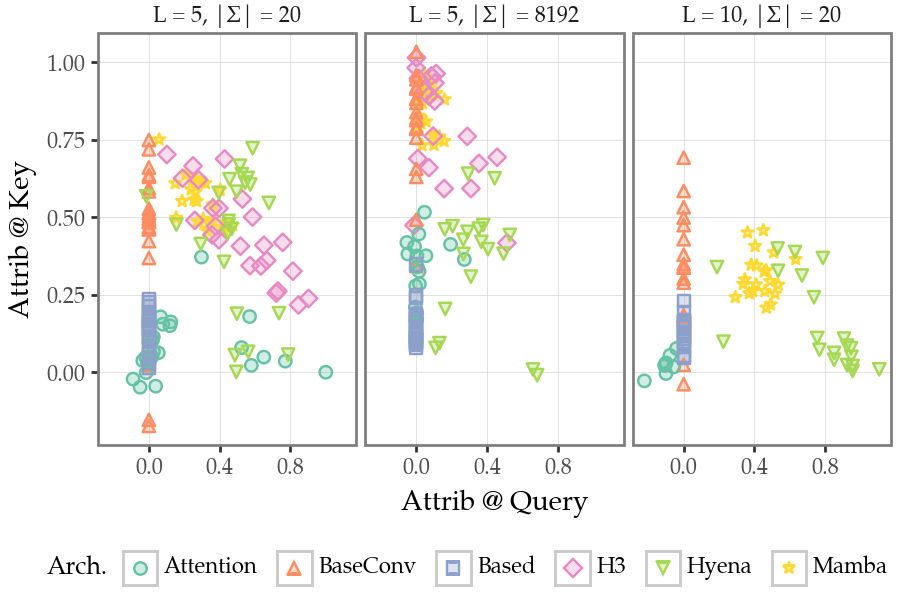

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_diff_q.pdf


In [14]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item", y="Association @ 1, query_item_orig", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Query", y="Attrib @ Key") +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()
plot.save("figs/atr_diff_q.pdf")

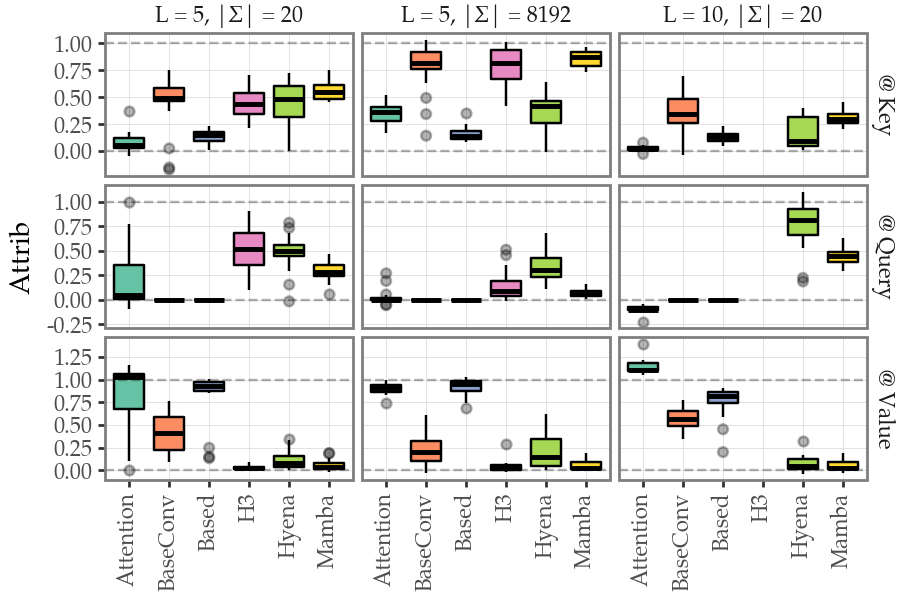

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 3 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_box.pdf


In [17]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.1]
subset_df_int_plot = subset_df_int_plot[["dim", "arch", "dataset", "Association @ 1, query_item", "Association @ 1, query_item_orig", "Association @ 1, target_item_orig"]]
subset_df_int_plot = subset_df_int_plot.melt(id_vars=["dim", "arch", "dataset"])
subset_df_int_plot["dataset"] = subset_df_int_plot["dataset"].map({
    "pcfg_easy": "L = 5, |Σ| = 20",
    "pcfg_easy_8192": "L = 5, |Σ| = 8192",
    "pcfg_medium": "L = 10, |Σ| = 20"
})
subset_df_int_plot["variable"] = subset_df_int_plot["variable"].map({
    "Association @ 1, query_item": "@ Query",
    "Association @ 1, query_item_orig": "@ Key",
    "Association @ 1, target_item_orig": "@ Value"
})
subset_df_int_plot["dataset"] = pd.Categorical(subset_df_int_plot["dataset"], categories=["L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20"], ordered=True)
subset_df_int_plot

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="value", fill="arch", group="arch", shape="arch")) +
    p9.facet_grid("variable ~ dataset", scales="free_y") +
    p9.scale_y_continuous(breaks=[-0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25]) +
    p9.geom_boxplot(outlier_alpha=0.3, color="black") +
    p9.labs(y="Attrib") +
    p9.theme(figure_size=(4.5, 3)) +
    p9.scale_fill_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="none",
        legend_justification_bottom=1,
        axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=1),
        axis_title_x=p9.element_blank()
    ) +
    p9.guides(
        fill=p9.guide_legend(
            nrow=1
        )
    ) +
    p9.geom_hline(yintercept=1, linetype="dashed", alpha=0.3) +
    p9.geom_hline(yintercept=0, linetype="dashed", alpha=0.3)
)
plot.show()
plot.save("figs/atr_box.pdf")

['Association @ 0, target_item_orig, attention_input', 'Association @ 0, query_item_orig, attention_input', 'Association @ 0, query_item, attention_input', 'Association @ 0, divider, attention_input']
['Association @ 0, target_item_orig, attention_output', 'Association @ 0, query_item_orig, attention_output', 'Association @ 0, query_item, attention_output', 'Association @ 0, divider, attention_output']
['Association @ 1, target_item_orig, attention_input', 'Association @ 1, query_item_orig, attention_input', 'Association @ 1, query_item, attention_input', 'Association @ 1, divider, attention_input']
['Association @ 1, target_item_orig, attention_output', 'Association @ 1, query_item_orig, attention_output', 'Association @ 1, query_item, attention_output', 'Association @ 1, divider, attention_output']


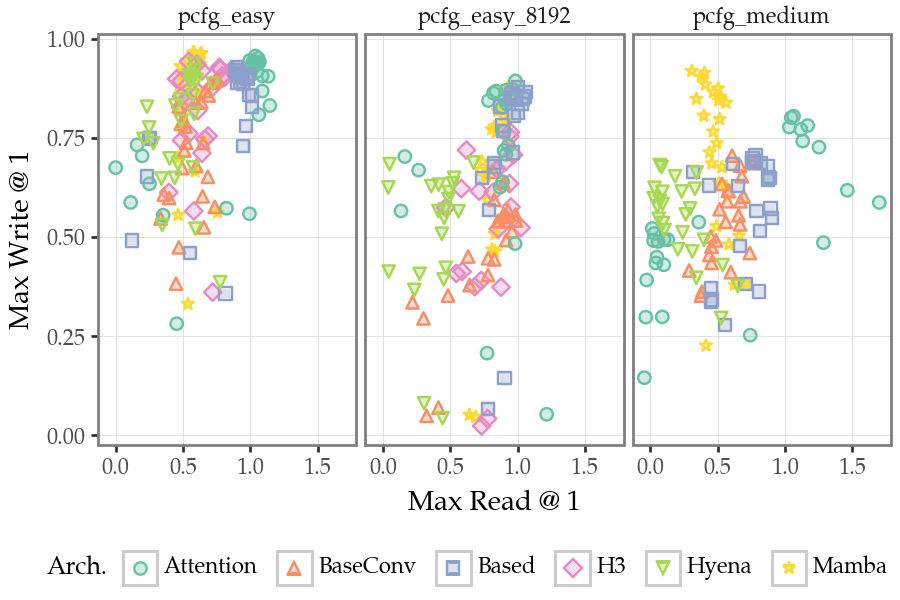

In [113]:
subset_df_int_plot = get_attrib_df(df, df_int, components=["attention_input", "attention_output", "mlp_input", "mlp_output"], prefix="PARENT")
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig, attention_input"] - subset_df_int_plot["Corrupted @ 0, target_item_orig, attention_input"]) > 0.005]

for layer in range(2):
    for label, component in {"Read": "attention_input", "Write": "attention_output"}.items():
        columns = [x for x in subset_df_int_plot.columns if x.startswith(f"Association @ {layer}") and x.endswith(component)]
        print(columns)
        subset_df_int_plot[f"{label} @ {layer}"] = subset_df_int_plot.apply(lambda row: max([row[col] for col in columns]), axis=1)
        
subset_df_int_plot["arch"] = pd.Categorical(subset_df_int_plot["arch"], categories=list(subset_df_int["arch"].unique()))
subset_df_int_plot["dim"] = pd.Categorical(subset_df_int_plot["dim"], categories=[x for x in sorted(subset_df_int_plot["dim"].unique())], ordered=True)

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Read @ 1", y="Likelihood", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(4.5, 3), legend_position="top") +
    p9.labs(color="Arch.", shape="Arch.", x="Max Read @ 1", y="Max Write @ 1") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()

# plot = (
#     p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="Association @ 0, query_item_orig, attention_output", color="arch", group="arch")) +
#     p9.facet_wrap("~dataset") +
#     # p9.geom_path(linetype="dashed") + 
#     p9.geom_boxplot() +
#     # p9.scale_x_log10() +
#     # p9.labs(color="Arch.", shape="Dim.", x="Attrib @ 1, Key", y="Attrib @ 1, Value") +
#     p9.theme(figure_size=(4.5, 3), legend_position="top")
# )
# plot.show()

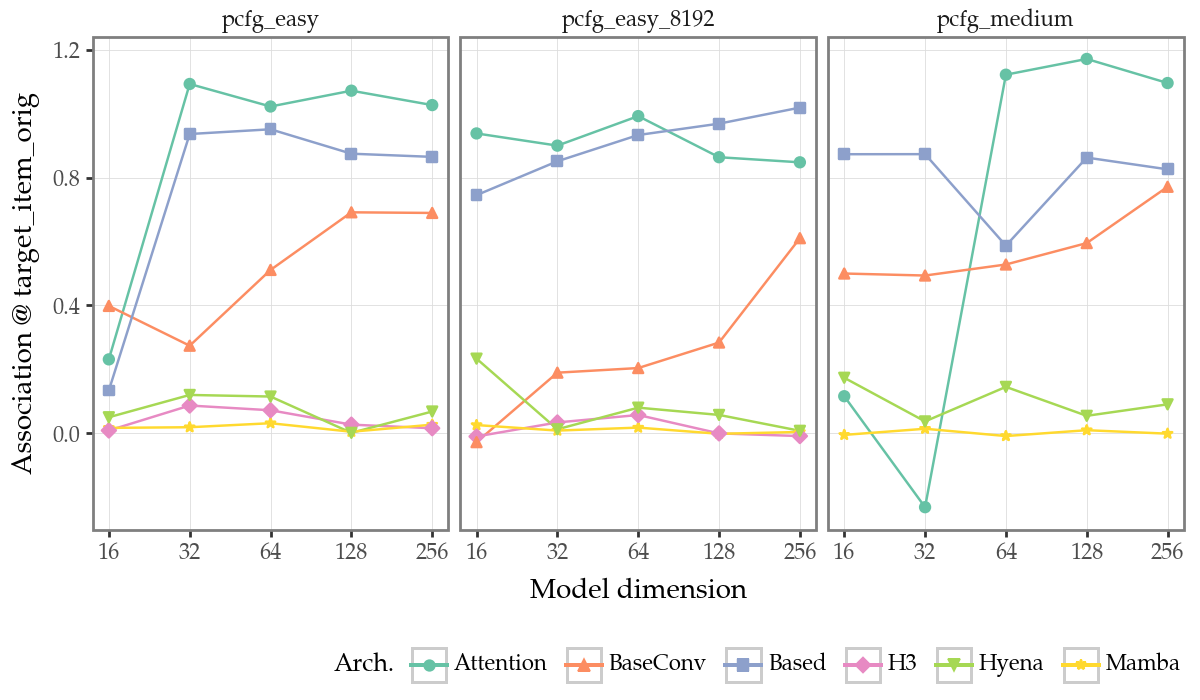

In [115]:
plot = (
    p9.ggplot(subset_df_int_best, p9.aes(x="dim", y="Association @ 1, target_item_orig", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dataset") +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Association @ target_item_orig", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.theme(figure_size=(6, 3.5)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()

In [125]:
[x for x in subset_df_int.columns if "Corrupted" in x]

['Corrupted @ 0, divider',
 'Corrupted @ 0, query_item',
 'Corrupted @ 0, query_item_orig',
 'Corrupted @ 0, target_item_orig']

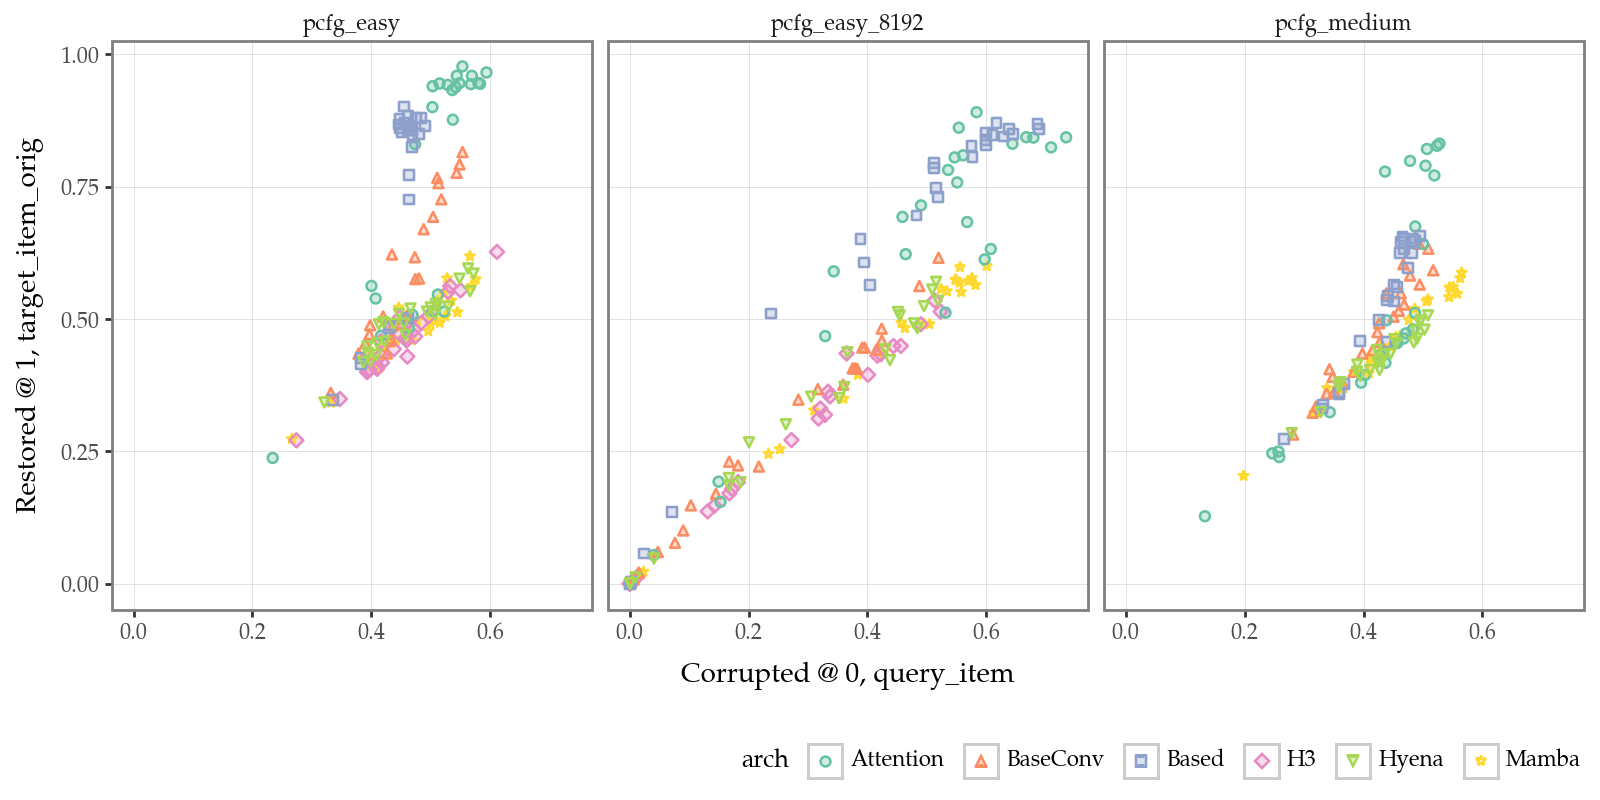

In [123]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot["dim"] = subset_df_int_plot["dim"].apply(lambda x: str(x))
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Corrupted @ 0, query_item", y="Restored @ 1, target_item_orig", color="arch", group="arch", shape="arch")) +
    p9.facet_wrap("~dataset") +
    # p9.geom_path(linetype="dashed") + 
    p9.geom_point(alpha=0.3) + 
    p9.geom_point(fill="none", stroke=0.5) +
    p9.theme(figure_size=(8, 4)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)
plot.show()

## ATR generalisation

In [18]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/test/SummaryEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/dev/SummaryEvaluator.csv",
]
df = read_df(dirs)
df

100%|██████████| 294/294 [00:22<00:00, 12.80it/s]


294


,variable,step,evaluator,step_rel,identifier,arch,dim,lr,layers,dataset,split,value
0,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/new_gen/attention...,Attention,128,0.00100,2,new_gen,dev,0.003125
1,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/new_gen/attention...,Attention,128,0.00100,2,new_gen,test,0.000000
2,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/new_gen/attention...,Attention,128,0.00010,2,new_gen,dev,0.003125
3,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/new_gen/attention...,Attention,128,0.00010,2,new_gen,test,0.000000
4,PARENT.query_item.argmax,0,SummaryEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/new_gen/attention...,Attention,128,0.00300,2,new_gen,dev,0.003125
...,...,...,...,...,...,...,...,...,...,...,...,...
43213,query_item.pred_prob,100000,SummaryEvaluator,1.0,/nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...,Mamba,64,0.00300,2,new_gen,test,0.468829
43214,query_item.pred_prob,100000,SummaryEvaluator,1.0,/nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...,Mamba,64,0.00030,2,new_gen,dev,0.879024
43215,query_item.pred_prob,100000,SummaryEvaluator,1.0,/nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...,Mamba,64,0.00030,2,new_gen,test,0.274468
43216,query_item.pred_prob,100000,SummaryEvaluator,1.0,/nlp/scr/rathi/tinylang_logs/new_gen/mamba___6...,Mamba,64,0.00003,2,new_gen,dev,0.699813


In [19]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df.copy().reset_index().pivot(index=["arch", "dim", "lr", "dataset"], columns="split", values="value").reset_index()
subset_df_best = subset_df_best[["dim", "arch", "dev", "test", "dataset"]]
subset_df_best = subset_df_best.iloc[subset_df_best.groupby(["dim", "arch", "dataset"])["dev"].idxmax()].reset_index()

pivoted = subset_df_best.copy()
pivoted["dev"] = pivoted["dev"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted["test"] = pivoted["test"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.melt(id_vars=["dim", "arch", "dataset", "index"])[["dim", "arch", "dataset", "split", "value"]]
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "split", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{value} \\
dataset & \multicolumn{10}{r}{new_gen} \\
split & \multicolumn{5}{r}{dev} & \multicolumn{5}{r}{test} \\
dim & 16 & 32 & 64 & 128 & 256 & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  &  &  &  &  &  \\
\midrule
Attention & 86.88 & 91.25 & 95.00 & 95.94 & 95.62 & 35.00 & 53.44 & 60.00 & 68.12 & 68.12 \\
BaseConv & 74.06 & 81.25 & 84.38 & 89.38 & 91.56 & 23.75 & 16.56 & 19.69 & 24.06 & 27.19 \\
Based & 84.06 & 91.56 & 92.19 & 93.12 & 93.44 & 35.62 & 42.50 & 48.44 & 46.25 & 47.19 \\
H3 & 81.88 & 88.44 & 88.44 & 91.25 & 91.88 & 47.81 & 44.06 & 49.38 & 54.37 & 56.88 \\
Hyena & 80.00 & 82.19 & 89.06 & 92.19 & 91.56 & 24.06 & 13.44 & 34.06 & 42.81 & 45.31 \\
Mamba & 89.69 & 93.12 & 96.88 & 97.50 & 98.12 & 52.50 & 32.50 & 46.56 & 59.38 & 65.00 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1443464/3747605971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


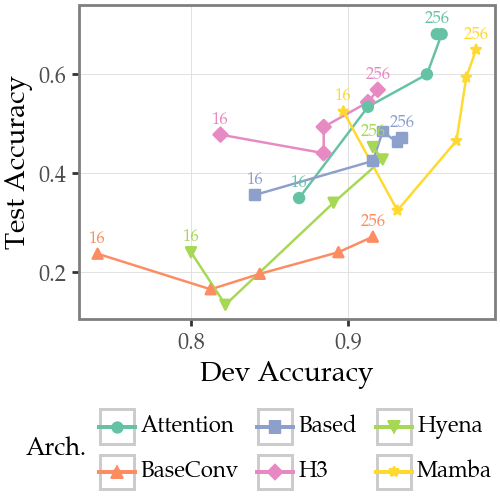

In [20]:
dev_test_combined_best = subset_df_best.copy()
# dev_test_combined_best = dev_test_combined_best.pivot(index=["arch", "dim", "dataset"], columns="split", values="value").reset_index()
plot = (
    p9.ggplot(dev_test_combined_best, p9.aes(x="dev", y="test", color="arch", group="arch", shape="arch")) +
    # p9.facet_wrap("~dim") +
    p9.geom_path() +
    p9.geom_point() +
    # p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(x="Dev Accuracy", y="Test Accuracy", color="Arch.", shape="Arch.") +
    p9.geom_text(dev_test_combined_best[dev_test_combined_best["dim"].isin([16, 256])], p9.aes(label="dim"), size=6, nudge_y=0.03) +
    p9.scale_color_brewer(type='qual', palette='Set2')
    # p9.xlim(0.7, 1) +
    # p9.ylim(0, 1)
)
plot.show()
# plot.save("figs/atr_gen_dev_test.pdf")

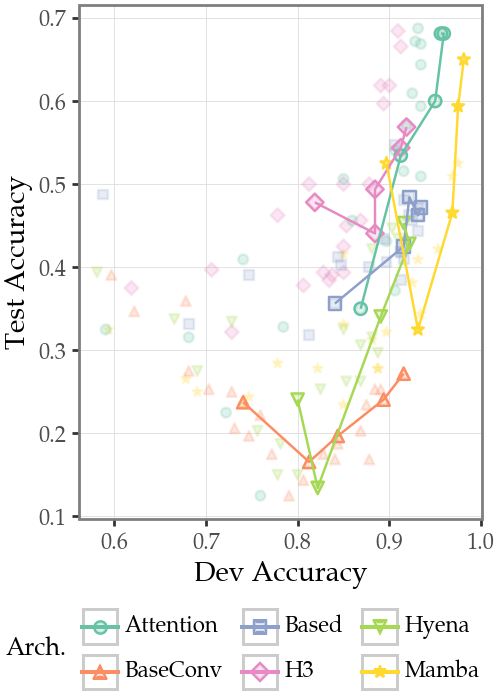

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen_dev_test.pdf


In [21]:
dev_test_combined = subset_df.copy()
dev_test_combined = dev_test_combined.pivot(index=["arch", "dim", "dataset", "lr"], columns="split", values="value").reset_index()
plot = (
    p9.ggplot(dev_test_combined, p9.aes(x="dev", y="test", color="arch", group="arch", shape="arch")) +
    # p9.facet_wrap("~dim") +
    # p9.geom_path() +
    p9.geom_point(alpha=0.2, stroke=0.5) +
    p9.geom_point(dev_test_combined_best, fill="none", stroke=0.5, size=2) +
    # p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(x="Dev Accuracy", y="Test Accuracy", color="Arch.", shape="Arch.") +
    # p9.geom_text(dev_test_combined[dev_test_combined["dim"].isin([16, 256])], p9.aes(label="dim"), size=6, nudge_y=0.03) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.geom_path(dev_test_combined_best) +
    p9.theme(
        figure_size=(2.5, 3.5)
    )
    # p9.xlim(0.7, 1) +
    # p9.ylim(0, 1)
)
plot.show()
plot.save("figs/atr_gen_dev_test.pdf")

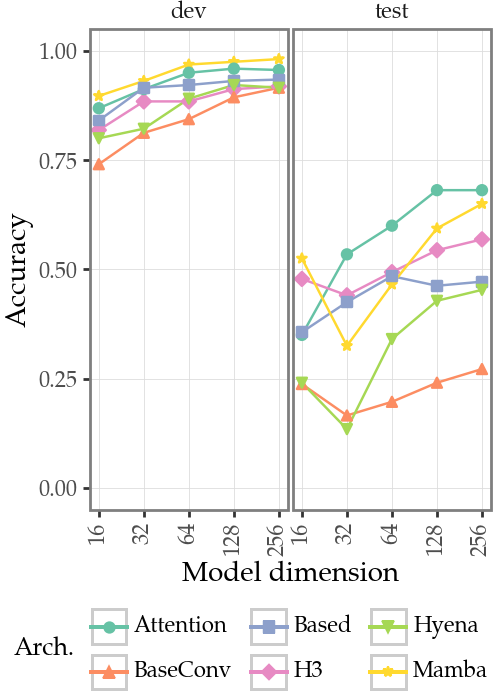

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen.pdf


In [23]:
# subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
# subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
# subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best.melt(id_vars=["dim", "arch", "dataset", "index"]), p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    # p9.geom_text(p9.aes(label="clean")) +
    p9.facet_wrap("~split") +
    p9.ylim(0, 1) +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        axis_text_x=p9.element_text(angle=90),
        figure_size=(2.5, 3.5)
    )
)
plot.show()
plot.save("figs/atr_gen.pdf")

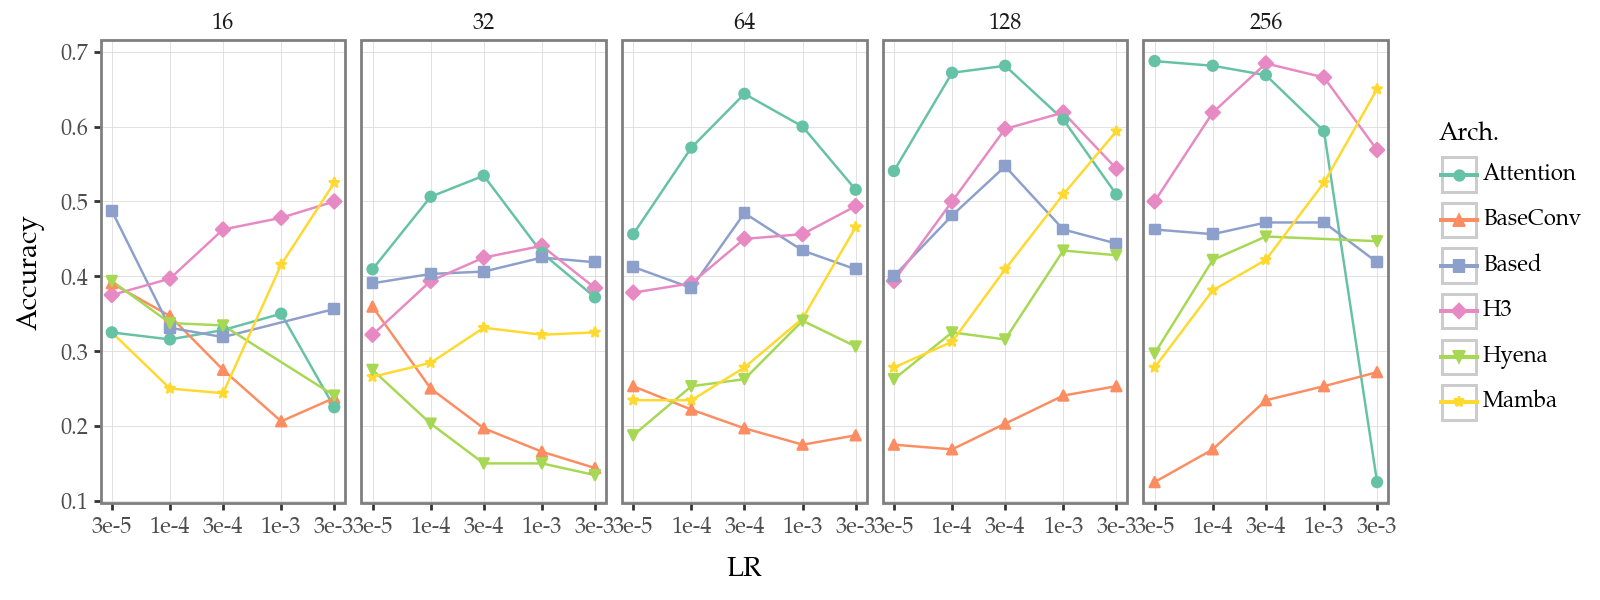

In [26]:
plot = (
    p9.ggplot(subset_df[subset_df["split"] == "test"], p9.aes(x="lr", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dim", nrow=1) +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.", shape="Arch.") +
    p9.theme(figure_size=(8, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="right",
    )
)
plot.show()

In [27]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/test/InterchangeEvaluator.csv",
    "/nlp/scr/rathi/tinylang_logs/new_gen/**/dev/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)
# df["arch"] = df.apply(lambda row: "Attention (NoPE)" if (row["arch"] == "Attention" and "_nope" in row["dataset"]) else row["arch"], axis=1)
# df["dataset"] = "ar_32"
df_int

 15%|█▍        | 44/294 [00:08<00:45,  5.48it/s]


KeyboardInterrupt: 

In [28]:
subset_df_int = get_attrib_df(df, df_int, corruption="query_item_orig", components="block_input", prefix="PARENT")
subset_df_int
# subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

# pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
# pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
# pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
# print(pivoted.to_latex())

,dim,arch,lr,dataset,split,0.PARENT.query_item_orig.divider.attention_input.kl_div,0.PARENT.query_item_orig.divider.attention_input.logit_diff,0.PARENT.query_item_orig.divider.attention_input.max_perc,0.PARENT.query_item_orig.divider.attention_input.max_perc_layer,0.PARENT.query_item_orig.divider.attention_input.prob_diff,...,Accuracy,Likelihood,"Association @ 0, target_item_orig","Association @ 0, query_item_orig","Association @ 0, query_item","Association @ 0, divider","Association @ 1, target_item_orig","Association @ 1, query_item_orig","Association @ 1, query_item","Association @ 1, divider"
0,16,Attention,0.00003,new_gen,dev,0.0,0.0,0.0,0.0,0.0,...,0.590625,0.328415,0.0,1.0,0.0,0.0,-0.010492,0.550743,0.458242,-0.011171
1,16,Attention,0.00003,new_gen,test,0.0,0.0,0.0,0.0,0.0,...,0.325000,0.197158,0.0,1.0,0.0,0.0,0.159674,0.410920,0.357918,-0.008310
2,16,Attention,0.00010,new_gen,dev,0.0,0.0,0.0,0.0,0.0,...,0.681250,0.582339,0.0,1.0,0.0,0.0,0.879392,0.203070,0.134168,-0.007532
3,16,Attention,0.00010,new_gen,test,0.0,0.0,0.0,0.0,0.0,...,0.315625,0.296600,0.0,1.0,0.0,0.0,0.937181,0.111370,0.069910,-0.004123
4,16,Attention,0.00030,new_gen,dev,0.0,0.0,0.0,0.0,0.0,...,0.784375,0.732756,0.0,1.0,0.0,0.0,1.041728,-0.006564,0.015457,-0.001451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,256,Mamba,0.00030,new_gen,test,0.0,0.0,0.0,0.0,0.0,...,0.421875,0.426448,0.0,1.0,0.0,0.0,0.013227,0.182982,0.498951,-0.014473
290,256,Mamba,0.00100,new_gen,dev,0.0,0.0,0.0,0.0,0.0,...,0.975000,0.971294,0.0,1.0,0.0,0.0,0.064271,0.662353,0.183579,0.033119
291,256,Mamba,0.00100,new_gen,test,0.0,0.0,0.0,0.0,0.0,...,0.525000,0.517553,0.0,1.0,0.0,0.0,-0.007451,0.330857,0.296773,0.021570
292,256,Mamba,0.00300,new_gen,dev,0.0,0.0,0.0,0.0,0.0,...,0.981250,0.980826,0.0,1.0,0.0,0.0,0.037677,0.566675,0.182490,0.002035


/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 3 rows containing non-finite values.


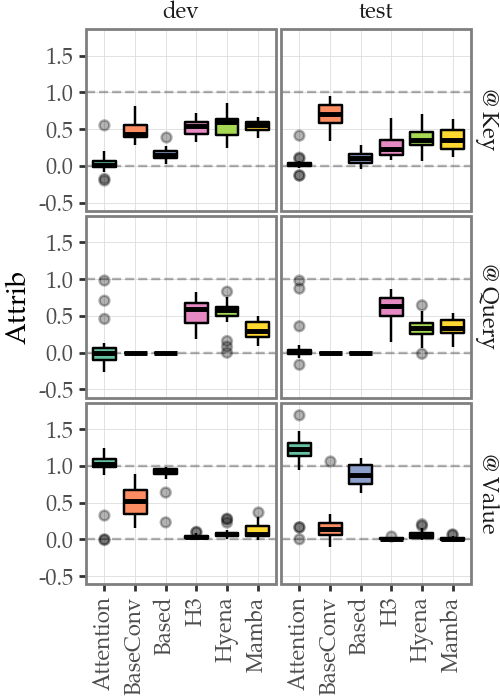

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen_box.pdf
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 3 rows containing non-finite values.


In [32]:
subset_df_int_plot = subset_df_int.copy()
# subset_df_int_plot = subset_df_int_plot[subset_df_int_plot["split"] == "test"]
# subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.1]
subset_df_int_plot = subset_df_int_plot[["dim", "arch", "dataset", "split", "Association @ 1, query_item", "Association @ 1, query_item_orig", "Association @ 1, target_item_orig"]]
subset_df_int_plot = subset_df_int_plot.melt(id_vars=["dim", "arch", "dataset", "split"])
subset_df_int_plot["variable"] = subset_df_int_plot["variable"].map({
    "Association @ 1, query_item": "@ Query",
    "Association @ 1, query_item_orig": "@ Key",
    "Association @ 1, target_item_orig": "@ Value"
})
subset_df_int_plot

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="value", fill="arch", group="arch", shape="arch")) +
    p9.facet_grid("variable ~ split", scales="free_y") +
    p9.scale_y_continuous(breaks=[0, 0.5, 1.0, 1.5, 2.0]) +
    p9.geom_hline(yintercept=1, linetype="dashed", alpha=0.3) +
    p9.geom_hline(yintercept=0, linetype="dashed", alpha=0.3) +
    p9.geom_boxplot(outlier_alpha=0.3, color="black") +
    # p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    # p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(y="Attrib") +
    p9.scale_fill_brewer(type='qual', palette='Set2') +
    p9.ylim(-0.5, 1.75) +
    p9.theme(
        legend_position="none",
        legend_justification_bottom=1,
        axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=1),
        axis_title_x=p9.element_blank(),
        figure_size=(2.5, 3.5)
    )
)
plot.show()
plot.save("figs/atr_gen_box.pdf")

144


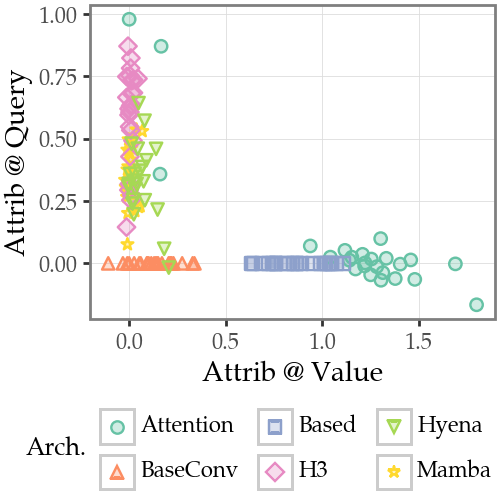

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen_diff.pdf


In [143]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.01]
print(len(subset_df_int_plot))
# subset_df_int_plot["dataset"] = subset_df_int_plot["dataset"].map({
#     "pcfg_easy": "L = 5, |Σ| = 20",
#     "pcfg_easy_8192": "L = 5, |Σ| = 8192",
#     "pcfg_medium": "L = 10, |Σ| = 20"
# })
# subset_df_int_plot["dataset"] = pd.Categorical(subset_df_int_plot["dataset"], categories=["L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20"], ordered=True)
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item", color="arch", group="arch", shape="arch")) +
    # p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Value", y="Attrib @ Query") +
    p9.scale_color_brewer(type='qual', palette='Set2')
)
plot.show()
plot.save("figs/atr_gen_diff.pdf")

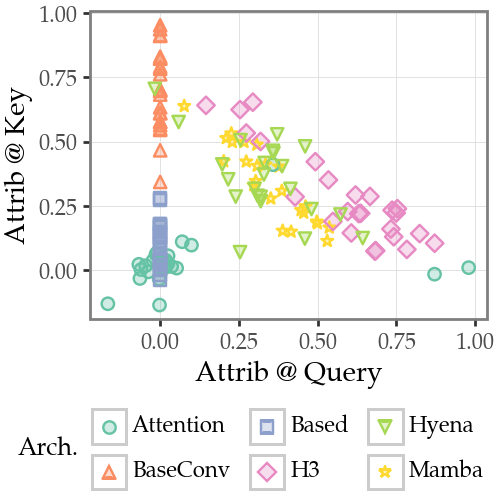

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/atr_gen_diff_q.pdf


In [144]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item", y="Association @ 1, query_item_orig", color="arch", group="arch", shape="arch")) +
    # p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(color="Arch.", shape="Arch.", x="Attrib @ Query", y="Attrib @ Key") +
    p9.scale_color_brewer(type='qual', palette='Set2')
)
plot.show()
plot.save("figs/atr_gen_diff_q.pdf")

## Multihop

In [204]:
!ls /nlp/scr/rathi/tinylang_logs

gen_sweep  multihop_3  new_gen_1  sibling
multihop   new_gen     new_gen_3  sibling_3


In [205]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/sibling/**/test/SummaryEvaluator.csv",
]
df = read_df(dirs)

100%|██████████| 135/135 [00:10<00:00, 12.33it/s]


135


In [206]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
dataset & \multicolumn{5}{r}{sibling} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 45.94 & 51.56 & 55.62 & 57.19 & 56.56 \\
BaseConv & 46.25 & 55.00 & 55.00 & 58.13 & 60.31 \\
Based & 47.19 & 53.44 & 55.31 & 56.25 & 56.25 \\
H3 & 50.31 & 55.00 & 55.62 & 54.37 & 55.62 \\
Hyena & 47.50 & 55.31 & 55.00 & 55.62 & 57.81 \\
Mamba & 48.12 & NaN & NaN & 59.06 & NaN \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1408702/2876777681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


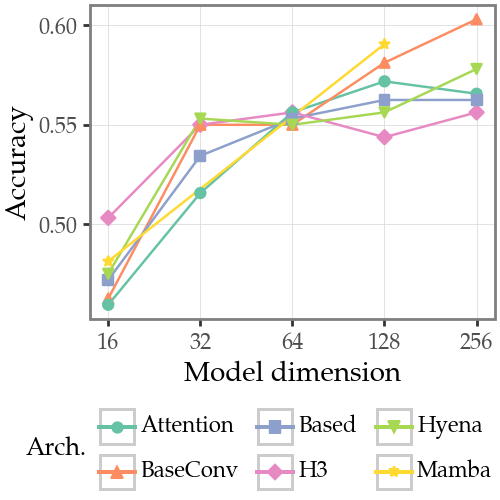

In [207]:
# subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
# subset_df["dataset"] = subset_df["dataset"].apply(lambda x: x.replace("_nope", ""))
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    # p9.geom_text(p9.aes(label="clean")) +
    # p9.facet_wrap("~dataset") +
    # p9.ylim(0, 1.05) +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.labs(y="Accuracy", x="Model dimension", color="Arch.", shape="Arch.") +
    p9.scale_color_brewer(type='qual', palette='Set2')
)
plot.show()

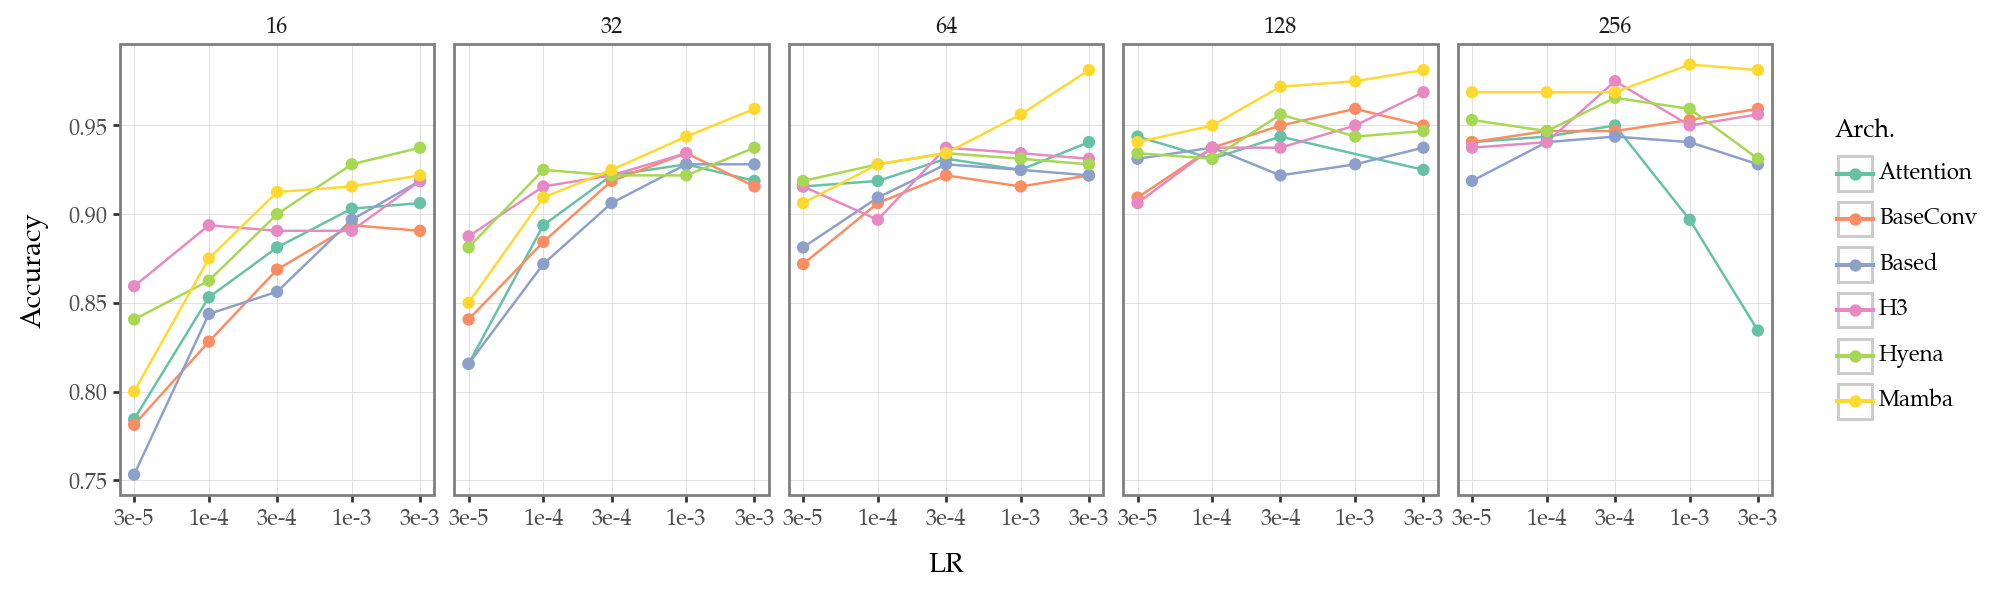

In [149]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap("~dim", nrow=1) +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Arch.") +
    p9.theme(figure_size=(10, 3)) +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        legend_position="right",
    )
)
plot.show()

In [150]:
dirs = [
    "/nlp/scr/rathi/tinylang_logs/multihop/**/test/InterchangeEvaluator.csv",
]
df_int = read_df(dirs)
df_int

100%|██████████| 148/148 [00:50<00:00,  2.91it/s]


148


,variable,step,evaluator,step_rel,identifier,arch,dim,lr,layers,dataset,value
0,0.SIBLING.query_item_orig.divider.attention_in...,0,InterchangeEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/multihop/attentio...,Attention,128,0.00010,2,multihop,0.000000
1,0.SIBLING.query_item_orig.divider.attention_in...,0,InterchangeEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/multihop/attentio...,Attention,128,0.00300,2,multihop,0.000000
2,0.SIBLING.query_item_orig.divider.attention_in...,0,InterchangeEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/multihop/attentio...,Attention,128,0.00030,2,multihop,0.000000
3,0.SIBLING.query_item_orig.divider.attention_in...,0,InterchangeEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/multihop/attentio...,Attention,128,0.00003,2,multihop,0.000000
4,0.SIBLING.query_item_orig.divider.attention_in...,0,InterchangeEvaluator,0.0,/nlp/scr/rathi/tinylang_logs/multihop/attentio...,Attention,16,0.00100,2,multihop,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3414007,original.SIBLING.target_item_orig.target_item_...,100000,InterchangeEvaluator,1.0,/nlp/scr/rathi/tinylang_logs/multihop/hyena___...,Hyena,64,0.00100,2,multihop,0.934919
3414008,original.SIBLING.target_item_orig.target_item_...,100000,InterchangeEvaluator,1.0,/nlp/scr/rathi/tinylang_logs/multihop/hyena___...,Hyena,64,0.00010,2,multihop,0.913042
3414009,original.SIBLING.target_item_orig.target_item_...,100000,InterchangeEvaluator,1.0,/nlp/scr/rathi/tinylang_logs/multihop/hyena___...,Hyena,64,0.00300,2,multihop,0.926990
3414010,original.SIBLING.target_item_orig.target_item_...,100000,InterchangeEvaluator,1.0,/nlp/scr/rathi/tinylang_logs/multihop/hyena___...,Hyena,64,0.00030,2,multihop,0.928538


In [68]:
subset_df_int = get_attrib_df(df, df_int, corruption="query_item_orig", components="block_input", prefix="SIBLING")
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{multihop} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Attention & 44.97 & 102.62 & 12.63 & 97.90 & 31.23 \\
BaseConv & 44.50 & 42.04 & 43.91 & 38.51 & 38.17 \\
Based & 49.99 & 55.99 & 62.89 & 61.08 & 60.52 \\
H3 & 37.89 & 48.12 & 34.33 & 37.52 & 29.77 \\
Hyena & 49.51 & 60.65 & 44.36 & 42.99 & 23.88 \\
Mamba & 36.43 & 42.29 & 61.45 & 53.33 & 63.00 \\
\bottomrule
\end{tabular}



148


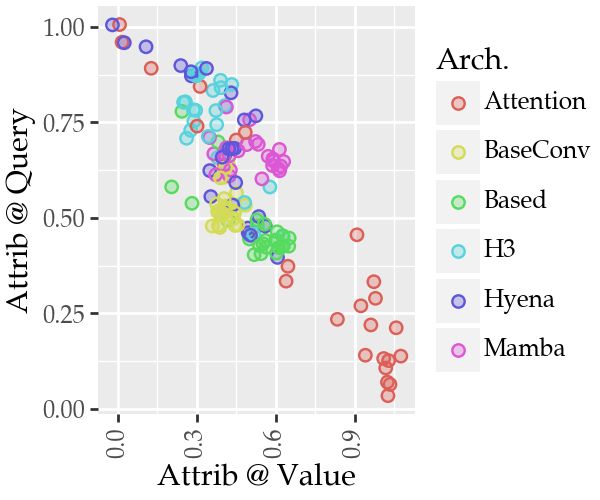

In [69]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.01]
print(len(subset_df_int_plot))
# subset_df_int_plot["dataset"] = subset_df_int_plot["dataset"].map({
#     "pcfg_easy": "L = 5, |Σ| = 20",
#     "pcfg_easy_8192": "L = 5, |Σ| = 8192",
#     "pcfg_medium": "L = 10, |Σ| = 20"
# })
# subset_df_int_plot["dataset"] = pd.Categorical(subset_df_int_plot["dataset"], categories=["L = 5, |Σ| = 20", "L = 5, |Σ| = 8192", "L = 10, |Σ| = 20"], ordered=True)
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, target_item_orig", y="Association @ 1, query_item", color="arch", group="arch")) +
    # p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(3, 2.5), legend_position="right") +
    p9.labs(color="Arch.", shape="Dim.", x="Attrib @ Value", y="Attrib @ Query")
)
plot.show()

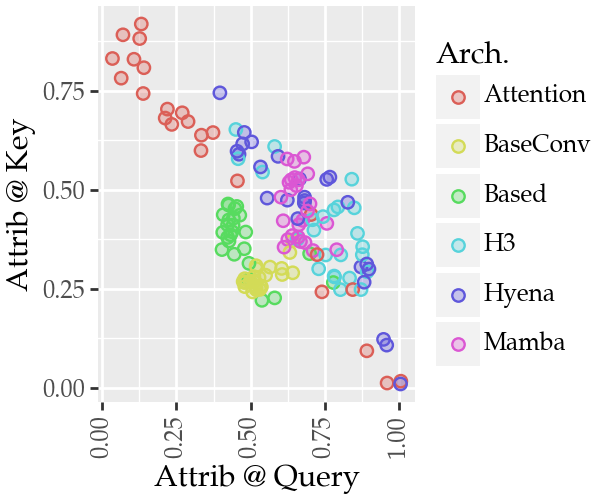

In [70]:
plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="Association @ 1, query_item", y="Association @ 1, query_item_orig", color="arch", group="arch")) +
    # p9.facet_wrap("~dataset") +
    p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    p9.geom_point(fill="none", size=2, stroke=0.5) + 
    # p9.scale_x_log10() +
    p9.theme(figure_size=(3, 2.5), legend_position="right") +
    p9.labs(color="Arch.", shape="Dim.", x="Attrib @ Query", y="Attrib @ Key")
)
plot.show()

## Mamba

In [45]:
dirs = [
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_mamba_ablation/**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_mamba_ablation_d_conv/**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_mamba_ablation_d_conv_2/**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_nope/mamba**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_more_lr/mamba**/test/SummaryEvaluator.csv",

]
df = read_df(dirs)
df["arch"] = df["arch"].map({
    "mamba_without_conv": 0,
    "mamba_1": 1,
    "mamba_2": 2,
    "mamba_3": 3,
    "Mamba": 4,
})
df["arch"] = pd.Categorical(df["arch"], categories=[0, 1, 2, 3, 4], ordered=True)
df["dataset"] = "ar_32"

100%|██████████| 175/175 [00:04<00:00, 36.50it/s]

175


In [46]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
0 & 0.31 & 0.62 & 1.25 & 0.00 & 0.00 \\
1 & 0.00 & 17.19 & 0.31 & 0.00 & 0.00 \\
2 & 5.94 & 25.94 & 91.25 & 39.06 & 6.25 \\
3 & 0.31 & 37.19 & 53.12 & 10.31 & 39.06 \\
4 & 10.00 & 76.88 & 80.62 & 89.69 & 91.25 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1425178/1062887037.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


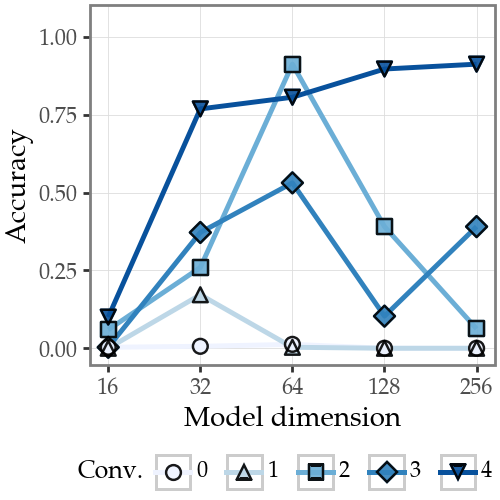

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/mamba_ar_32.pdf
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


In [76]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, alpha=0.9, color="black", size=2.5) +
    # Optional: label points with accuracy
    # p9.geom_text(p9.aes(label="clean"), size=6, va='bottom') +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Conv.", shape="Conv.") +
    p9.scale_color_brewer(type='seq', palette='Blues') +
    p9.theme(
        figure_size=(2.5, 2.5),
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    )
)

plot.show()
plot.save("figs/mamba_ar_32.pdf", dpi=300)

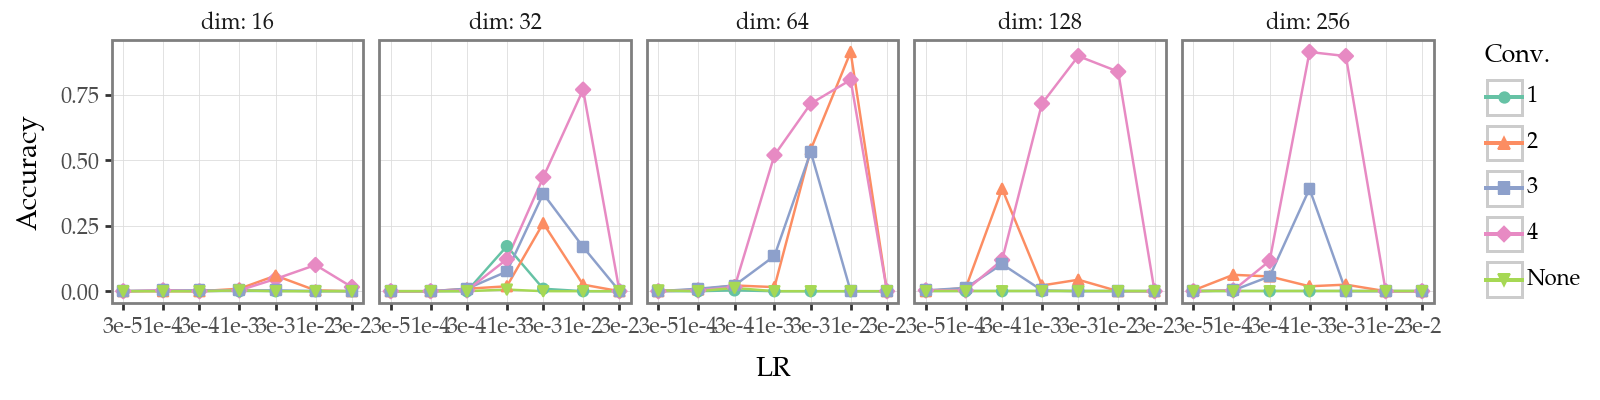

In [26]:
plot = (
    p9.ggplot(subset_df, p9.aes(x="lr", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_grid("~dim", labeller="label_both") +
    p9.scale_x_log10(breaks=[3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]) +
    p9.labs(y="Accuracy", x="LR", color="Conv.", shape="Conv.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(8, 2),
        legend_position="right",
    )
)
plot.show()

In [48]:
dirs = [
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_mamba_ablation/**/test/InterchangeEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_mamba_ablation_d_conv/**/test/InterchangeEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_mamba_ablation_d_conv_2/**/test/InterchangeEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_nope/mamba**/test/InterchangeEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_more_lr/mamba**/test/InterchangeEvaluator.csv",

]
df_int = read_df(dirs)
df_int["arch"] = df_int["arch"].map({
    "mamba_without_conv": 0,
    "mamba_1": 1,
    "mamba_2": 2,
    "mamba_3": 3,
    "Mamba": 4,
})
df_int["arch"] = pd.Categorical(df_int["arch"], categories=[0, 1, 2, 3, 4], ordered=True)
df_int["dataset"] = "ar_32"

  1%|          | 2/175 [00:00<00:26,  6.46it/s]

100%|██████████| 175/175 [00:16<00:00, 10.61it/s]


175


In [49]:
subset_df_int = get_attrib_df(df, df_int)
subset_df_int_best = subset_df_int.iloc[subset_df_int.groupby(["dim", "arch", "dataset"])["Accuracy"].idxmax().dropna()].reset_index() # get most accurate ones

pivoted = subset_df_int_best.copy()[["dim", "arch", "dataset", "Association @ 1, target_item_orig"]]
pivoted["Association @ 1, target_item_orig"] = pivoted["Association @ 1, target_item_orig"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{Association @ 1, target_item_orig} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
0 & -0.20 & -0.02 & 151.30 & 0.19 & 0.05 \\
1 & -0.03 & 100.02 & 1.10 & 0.09 & 0.48 \\
2 & 1.07 & 1.32 & -0.00 & 2.91 & 103.98 \\
3 & -7.72 & -0.16 & 0.17 & -21.00 & -0.47 \\
4 & -0.02 & 0.02 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1425178/3967278718.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


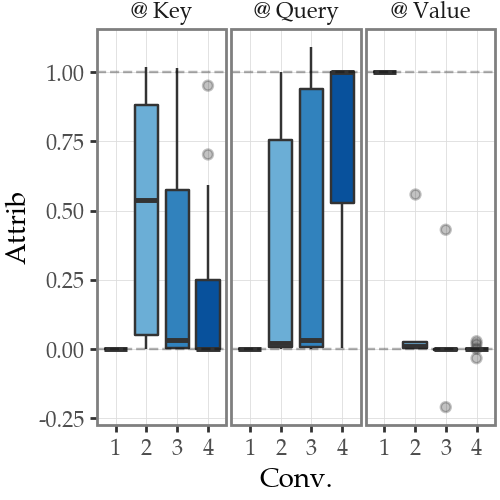

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/mamba_ar_box.pdf
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


In [83]:
subset_df_int_plot = subset_df_int.copy()
subset_df_int_plot = subset_df_int_plot[(subset_df_int_plot["Original @ 0, target_item_orig"] - subset_df_int_plot["Corrupted @ 0, target_item_orig"]) > 0.01]
subset_df_int_plot = subset_df_int_plot[["dim", "arch", "dataset", "Association @ 1, query_item", "Association @ 1, query_item_orig", "Association @ 1, target_item_orig"]]
subset_df_int_plot = subset_df_int_plot.melt(id_vars=["dim", "arch", "dataset"])
subset_df_int_plot["variable"] = subset_df_int_plot["variable"].map({
    "Association @ 1, query_item": "@ Query",
    "Association @ 1, query_item_orig": "@ Key",
    "Association @ 1, target_item_orig": "@ Value"
})

plot = (
    p9.ggplot(subset_df_int_plot, p9.aes(x="arch", y="value", fill="arch", group="arch", shape="arch", outlier_color="arch")) +
    p9.facet_grid("~variable", scales="free_y") +
    p9.scale_y_continuous(breaks=[-0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25]) +
    p9.geom_boxplot(outlier_alpha=0.3) +
    # p9.geom_point(stroke=0, alpha=0.3, size=2) + 
    # p9.geom_point(fill="none", size=2, stroke=0.5) + 
    p9.labs(x="Conv.", y="Attrib") +
    p9.theme(figure_size=(2.5, 2.5)) +
    p9.scale_fill_brewer(type='seq', palette='Blues') +
    p9.theme(
        legend_position="none",
        legend_justification_bottom=1,
        # axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=1)
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=1
        )
    ) +
    p9.geom_hline(yintercept=1, linetype="dashed", alpha=0.3) +
    p9.geom_hline(yintercept=0, linetype="dashed", alpha=0.3)
)
plot.show()
subset_df_int_plot.isna().sum()
plot.save("figs/mamba_ar_box.pdf")

In [95]:
dirs = [
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_based_ablation/base**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_nope/base**/test/SummaryEvaluator.csv",
    "/nlp/scr/aryaman/tinylang/experiments/logs/ar_32_more_lr/base**/test/SummaryEvaluator.csv",

]
df = read_df(dirs)
df["arch"] = df["arch"].map({
    "Based": "Based",
    "based_long_only": "Based (long)",
    "BaseConv": "BaseConv",
    "base_conv_long_only": "BaseConv (long)",
})
df["arch"] = pd.Categorical(df["arch"], categories=["Based", "Based (long)", "BaseConv", "BaseConv (long)"], ordered=True)
df["dataset"] = "ar_32"

100%|██████████| 120/120 [00:02<00:00, 47.23it/s]

120


In [96]:
subset_df = df[(df["variable"] == "query_item.argmax") & (df["step_rel"] == 1.0)]
subset_df_best = subset_df[["dim", "arch", "value", "dataset"]].groupby(["dim", "arch", "dataset"]).max().reset_index()

pivoted = subset_df_best.copy()
pivoted
pivoted["value"] = pivoted["value"].apply(lambda x: f"{x * 100:.2f}".replace("%", "\%"))
pivoted = pivoted.pivot(index=["arch"], columns=["dataset", "dim"]).sort_index(axis=1)
print(pivoted.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
dataset & \multicolumn{5}{r}{ar_32} \\
dim & 16 & 32 & 64 & 128 & 256 \\
arch &  &  &  &  &  \\
\midrule
Based & 24.38 & 93.12 & 99.06 & 98.75 & 99.06 \\
Based (long) & 0.31 & 1.56 & 3.75 & 5.94 & 9.06 \\
BaseConv & 0.00 & 0.94 & 3.75 & 6.56 & 9.69 \\
BaseConv (long) & 0.31 & 1.56 & 5.00 & 5.62 & 7.50 \\
\bottomrule
\end{tabular}



/tmp/user/23259/ipykernel_1425178/1062887037.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


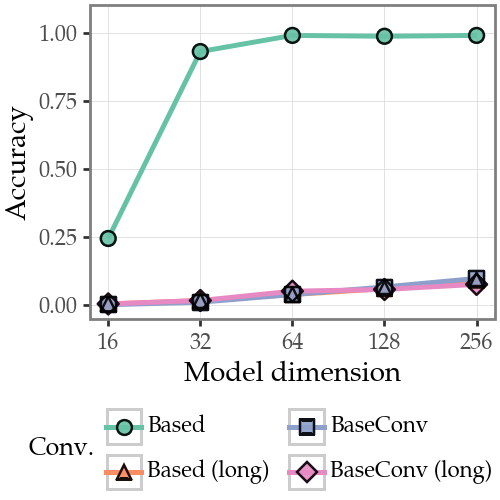

/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 2.5 in image.
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figs/based_ar_32.pdf
/nlp/scr/aryaman/tinylang/.venv/lib/python3.11/site-packages/plotnine/scales/scale_shape.py:88: PlotnineWarning: Using shapes for an ordinal variable is not advised.


In [98]:
subset_df_best["clean"] = subset_df_best["value"].apply(lambda x: f"{x * 100:.2f}")

plot = (
    p9.ggplot(subset_df_best, p9.aes(x="dim", y="value", group="arch", color="arch", shape="arch")) +
    p9.geom_line(size=1) +
    p9.geom_point(size=2.5, alpha=0.9) +
    p9.geom_point(fill="none", stroke=0.5, alpha=0.9, color="black", size=2.5) +
    # Optional: label points with accuracy
    # p9.geom_text(p9.aes(label="clean"), size=6, va='bottom') +
    p9.scale_x_log10(breaks=[16, 32, 64, 128, 256]) +
    p9.scale_y_continuous(limits=(0, 1.05)) +
    p9.labs(y="Accuracy", x="Model dimension", color="Conv.", shape="Conv.") +
    p9.scale_color_brewer(type='qual', palette='Set2') +
    p9.theme(
        figure_size=(2.5, 2.5),
        legend_position="bottom",
        legend_justification_bottom=1,
    ) +
    p9.guides(
        color=p9.guide_legend(
            nrow=2
        )
    )
)

plot.show()
plot.save("figs/based_ar_32.pdf", dpi=300)

## Sus stuff